# ECON240 (Regression), Fall 2021, Problem Set 3
Satej Soman, satej@berkeley.edu

## preliminaries: install needed packages, import libraries, and set up plotting options

In [144]:
! pip3 install numpy scipy matplotlib seaborn pandas requests

In [234]:
import io
from itertools import dropwhile, takewhile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns

np.set_printoptions(edgeitems = 30, linewidth = 5000, formatter = dict(float = lambda x: "%.5g" % x))

sns.set_theme(context = "notebook", style = "white", palette = "bright")
plt.rc("axes.spines", top = False, right = False)
plt.rc('font',**{'family':'sans-serif','sans-serif':'Helvetica Neue'})
plt.rc('figure', dpi = 200)


# 1. K-Normal Means, problem (5)

First, let's set up the cosine basis elements, as well as the bimodal and steps functions discussed in Efromovich.

In [2]:
def ϕ(k, x):
    """ kth basis element of the cosine orthonormal system """
    return np.sqrt(2) * np.cos(np.pi * (k-1) * x[:, None])

μ_2, σ_2 = 0.7, 0.08
μ_1, σ_1 = 0.4, 0.12
mode_1 = stats.norm(μ_1, σ_1)
mode_2 = stats.norm(μ_2, σ_2)
def mb(x, mode_1 = mode_1, mode_2 = mode_2):
    """ bimodal test function """ 
    return (mode_1.pdf(x) + mode_2.pdf(x))/2

def ms(x):
    """ steps test function """
    return (
        0.6 * ((0   <= x) & (x <  1/3)) +
        0.9 * ((1/3 <= x) & (x <  3/4)) +
        1.7 * ((3/4 <= x) & (x <= 1)) 
    )

Next, set the random seed for reproducibility, and set up the problem parameters.

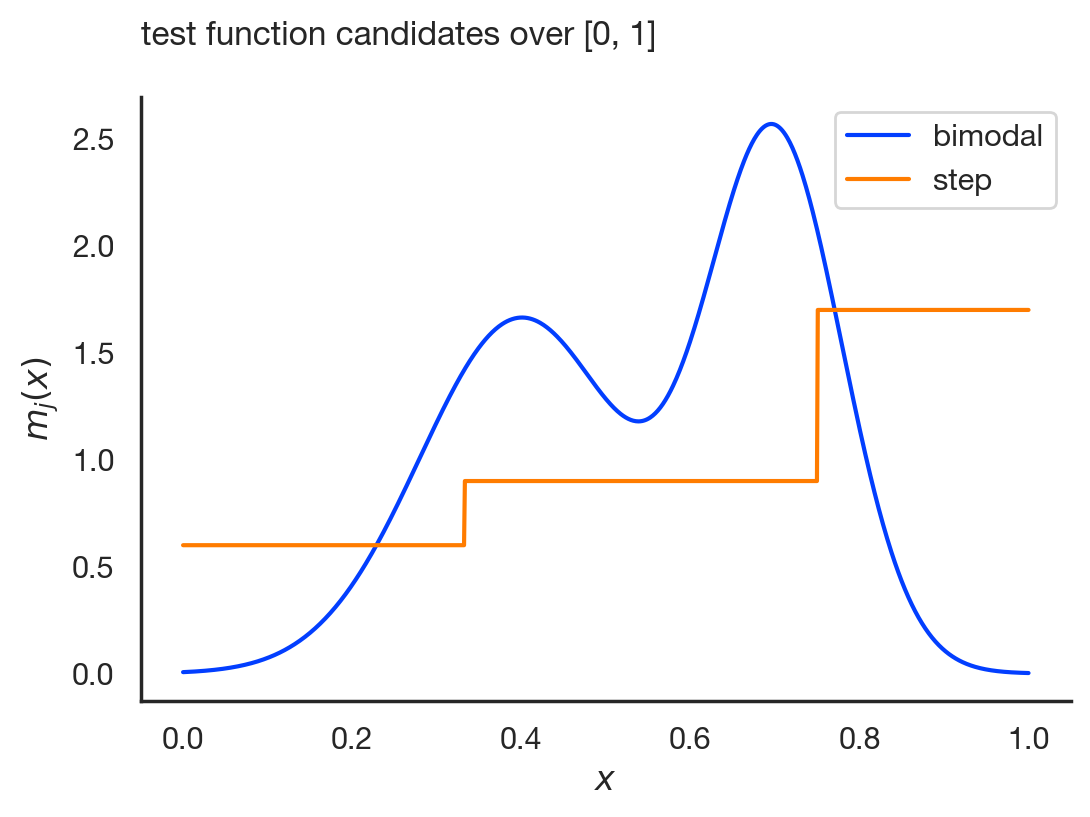

In [235]:
np.random.seed(0)
t = 1000 # number of samples
N = 1000 # sample size
σ = 1/2
K = 20

X = np.arange(1, N+1)/(N+1)
U = stats.norm.rvs(size = (t, N))

Y = lambda m, x, u: m(x) + σ*u
Z = lambda k, x, y: np.mean(ϕ(k, x) * y)

Yb = Y(mb, X, U)
Ys = Y(ms, X, U)

Zb = [Z(k, X, Yb) for k in range(1, K+1)]
Zs = [Z(k, X, Ys) for k in range(1, K+1)]

x = np.linspace(0, 1, 1000)
plt.plot(x , mb(x), label = "bimodal")
plt.plot(x , ms(x), label = "step")
plt.ylabel("$m_j(x)$")
plt.xlabel("$x$")
plt.title("test function candidates over [0, 1]\n", loc = "left")
plt.legend()
plt.show()

# 2. K-Normal Means, Application

### We start by downloading and formatting the data, and by creating the (non-orthonormal) design matrix. I made the decision to drop rows with NA values for `logHL`.

In [223]:
# download the data
hj_raw = requests.get("https://web.stanford.edu/~chadj/HallJones400.asc").text.split("\n")

# extract the relevant rows for Table 2 and read them into a dataframe 
table2_rows = io.StringIO("\n".join(
    takewhile(lambda _: _, 
    dropwhile(lambda _: not _.startswith("Code  Country"), hj_raw))
))
hj_table2 = pd.read_fwf(table2_rows, skiprows = [1])

# split some non-fixed-width columns and perform some data reorganization
for colname in [hj_table2.columns[_] for _ in [0, 2, -1]]:
    hj_table2[colname.split()] = hj_table2[colname].str.split(expand = True, n = 1)
    hj_table2.drop(columns = colname, inplace = True)
hj_table2.sort_values(by = "Latitude", inplace = True)
hj_table2.set_index("Country", inplace = True)
hj_table2.dropna(subset = ["logHL", "Latitude"], inplace = True)

(hj_table2)

,Sample?,logKL,alogKY,School,logHL,logA,logL,Mining,EcOrg,SocInf,YrsOpen,GADP,EngFrac,EurFrac,Code,Imputed?,logYL,log(FrankRom),Latitude
Country,,,,,,,,,,,,,,,,,,,
Kenya,1,7.91873,0.15947,3.09000,0.41406,7.02625,16.13396,0.002,5,0.31306,0.044,0.582,0.000,0.000,KEN,0,7.59978,2.524,-0.513
Zaire,1,6.56787,-0.24324,2.24000,0.30016,6.99743,16.40688,0.040,3,0.11267,0.000,0.225,0.000,0.000,ZAR,1,7.05435,2.194,-0.569
Comoros,1,7.76796,0.31784,3.02373,0.40518,6.40925,12.20150,0.072,5,0.50838,0.450,0.567,0.000,0.000,COM,1,7.13227,3.845,-11.671
Peru,1,9.80231,0.38396,5.79000,0.71679,7.93364,15.69632,0.022,3,0.46361,0.489,0.438,0.000,0.564,PER,0,9.03439,1.950,-11.794
Zambia,1,8.77689,0.64036,4.35000,0.57135,6.28446,14.73804,0.204,1,0.23422,0.044,0.424,0.000,0.000,ZMB,0,7.49617,2.625,-12.942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Iceland,1,11.10710,0.47343,7.89000,0.92889,8.75793,11.79618,-0.014,5,0.89574,0.805,0.986,0.000,0.000,ISL,1,10.16024,3.499,63.892
Sierra leone,1,6.15930,-0.78506,1.72000,0.23048,8.28399,14.18447,0.061,5,0.19900,0.000,0.398,0.000,0.000,SLE,0,7.72941,3.325,8.701
Panama,1,9.89313,0.45939,6.30000,0.76830,7.74667,13.62512,0.001,3,0.33445,0.259,0.410,0.140,0.805,PAN,1,8.97435,3.160,9.206


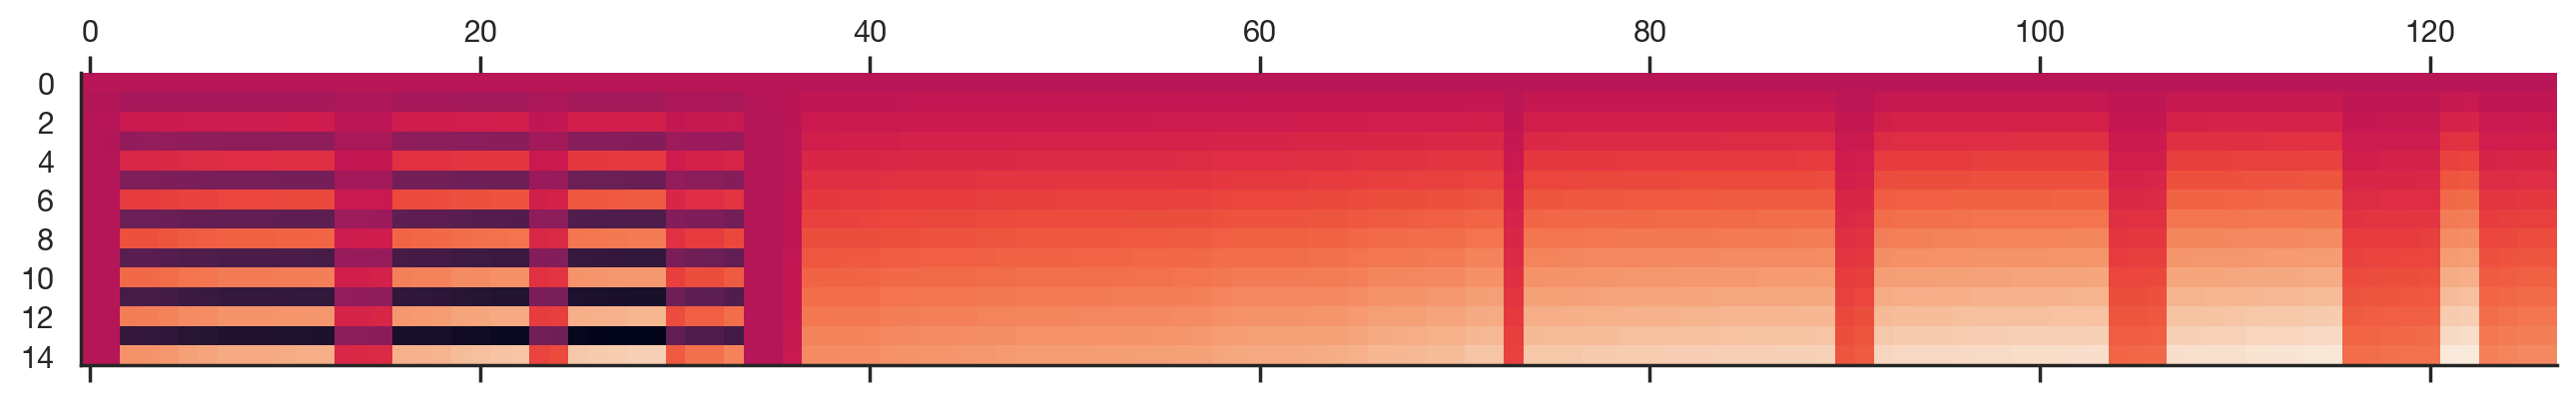

In [236]:
# extract the latitude and create the design matrix
latitude = hj_table2["Latitude"].astype(float).to_numpy()
design_matrix = (latitude ** np.arange(0, 15)[:, None]).T

# extract the target variable for the prediction task 
Y = hj_table2["logHL"]

# take a look at the design matrix to make sure it looks right
plt.matshow(np.arcsinh(design_matrix).T)

### Next, we need to apply the Gram-Schmidt procedure to get an orthonormal version of our design matrix:

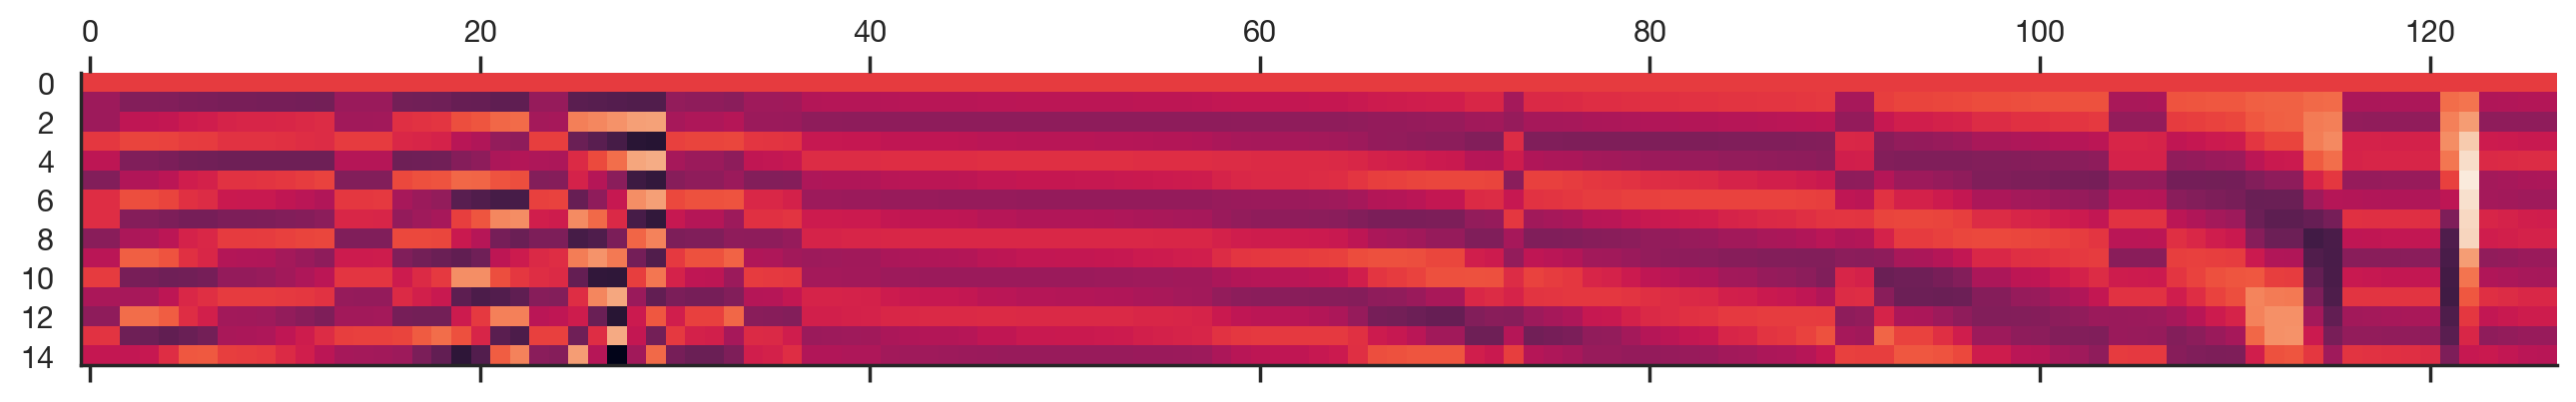

In [237]:
def gram_schmidt(X):
    # start with empty set so first vector is automatically normalized
    U = [] 
    for x in X.T: # iterate over columns 
        # project each vector onto existing set 
        u = x - sum([x.dot(u)/u.dot(u) * u for u in U]) 
        # add normalized non-zero vector to set 
        if np.any(u): U.append(u/np.linalg.norm(u)) 
    return np.array(U).T

X = orthonormal_basis = gram_schmidt(design_matrix)

plt.matshow(np.arcsinh(orthonormal_basis).T)

### We can now compute the conditional mean of log(GDP/worker) given latitude, $\mathbb{E}\left[ \log(h_i)\,|\, \Lambda = \lambda_i \right]$, where $h_i \equiv H/L$ (cf Hall and Jones, 1998) using the four specified methods.

### (i) MLE: The maximum likelihood estimate is just the OLS estimate:

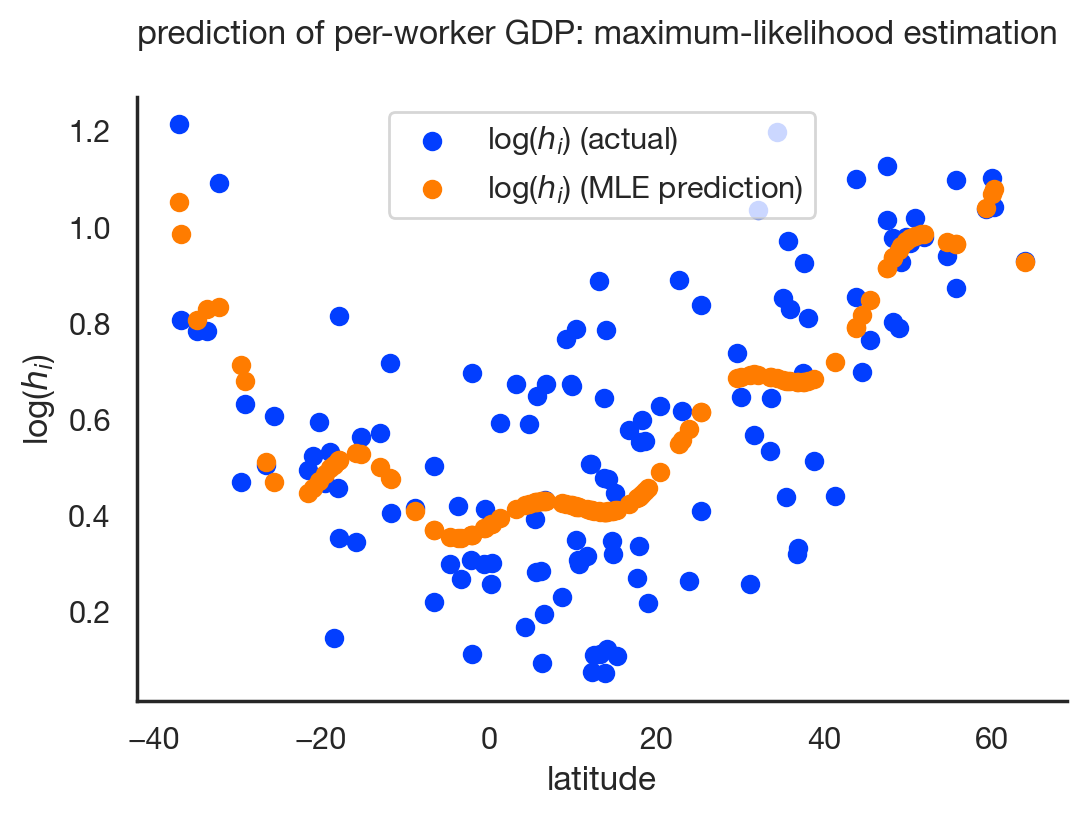

In [238]:
β = np.linalg.pinv(X.T @ X) @ X.T @ Y
Y_hat_mle = X @ β
Y_hat_mle
n = np.arange(0, len(Y))
plt.scatter(latitude, Y,         label = "log($h_i$) (actual)")
plt.scatter(latitude, Y_hat_mle, label = "log($h_i$) (MLE prediction)")
plt.xlabel("latitude")
plt.ylabel("log($h_i$)")
plt.title("prediction of per-worker GDP: maximum-likelihood estimation\n", loc = "left")
plt.legend()
plt.show()


In [233]:
np.var(Y)

0.08315839860028523

, soft-thresholding, ordered subset selection, and Efromovich's method